Notebook to give a example to plot the cos sim figure of hidden states of llama3

In [16]:
# Run the model on certain task for 100 samples and save the hidden states
# you can easily change the model and arg to get desired visualization

# Note that llama2-70b-hf need more GPUs (depend on your memory),
# pls add parallelize=True, for 70b, eg:
# --model_args pretrained=meta-llama/Llama-2-70b-hf,parallelize=True \

# To keep code clean, we only add hidden_state_folder_path option for
# baseline method, you can easily modify routing_llama.py/LlamaModel/forward
# to add save hidden states for other method(skip, etc) as well.

! cd gpt
! CUDA_VISIBLE_DEVICES=0 lm_eval --model hf \
    --model_args pretrained=meta-llama/Llama-2-7b-hf \
    --tasks lambada_openai \
    --batch_size 8 \
    --limit 100 \
    --method baseline \
    --hidden_state_folder_path ./lambada_llama2

2024-07-25:17:22:06,510 INFO     [__main__.py:272] Verbosity set to INFO
2024-07-25:17:22:10,120 WARNING  [__main__.py:287]  --limit SHOULD ONLY BE USED FOR TESTING.REAL METRICS SHOULD NOT BE COMPUTED USING LIMIT.
2024-07-25:17:22:10,121 INFO     [__main__.py:356] Selected Tasks: ['lambada_openai']
2024-07-25:17:22:10,123 INFO     [evaluator.py:132] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2024-07-25:17:22:10,123 INFO     [evaluator.py:178] Initializing hf model, with arguments: {'pretrained': 'meta-llama/Llama-2-7b-hf'}
2024-07-25:17:22:10,125 INFO     [huggingface.py:163] Using device 'cuda'
/home/qisun/code/transformer-as-painter/painter_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards

In [17]:
# Fetch from ./lambada_llama2
import torch
from pathlib import Path

directory = './lambada_llama2'
dir_path = Path(directory)

layers_hidden_states = []
pt_files = list(dir_path.glob('*.pt'))
for fp in pt_files:
    layers_hidden_states.append(torch.load(fp))

In [18]:
# Compute the cos-sim
import torch.nn.functional as F

cos_sim_pool = []

# Loop each batched data samples
for tensor_list in layers_hidden_states:
    num_layer = len(tensor_list) - 1
    batch_size, seq_len, hidden_dim = tensor_list[0].shape
    cos_similarities = torch.zeros(num_layer+1, num_layer+1) # count the start hidden state
    # To compute the cos-sim, we first flattn the sequence
    reshaped_tensors = [tensor.view(batch_size, -1) for tensor in tensor_list]
    for i in range(num_layer + 1):
        for j in range(num_layer + 1):
            cos_sim = F.cosine_similarity(reshaped_tensors[i], reshaped_tensors[j])
            cos_similarities[i,j] = cos_sim.mean(0) # avg along batch dim
    cos_sim_pool.append(cos_similarities)

# Average cos-sim over 100 samples
final_cos_sim = torch.stack(cos_sim_pool, dim=0).mean(0)

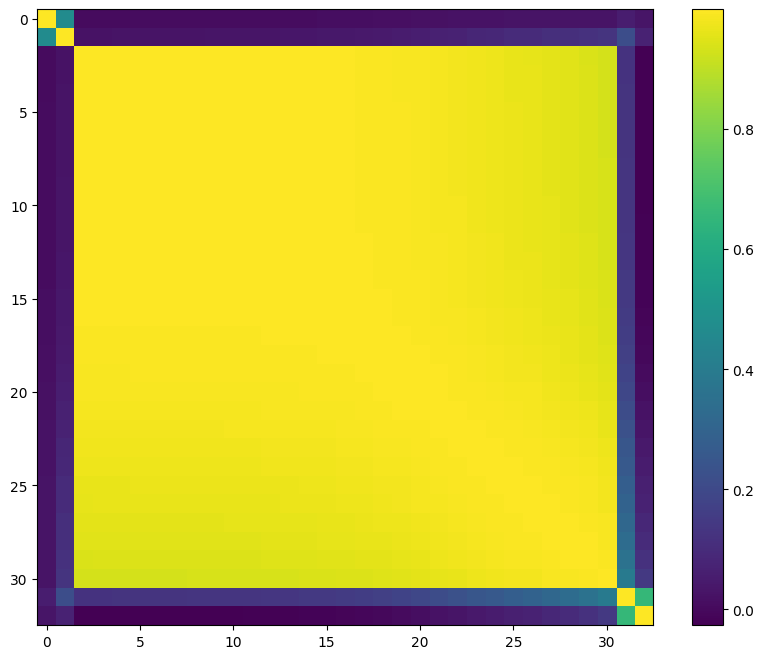

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(final_cos_sim, cmap='viridis')
plt.colorbar()
plt.show()